In [24]:
import pandas as pd
import numpy as np

df = pd.read_csv('students_simple.csv')

selected_columns = df.iloc[:, [1, 3]]
print(selected_columns)

    mass   iq
0     45   95
1     61  115
2     56  111
3     48   97
4     54  105
5     58   98
6     51  109
7     62  120
8     70  122
9     72   92
10    73  110
11    64  102
12    73  108
13    68  100
14    81  104
15    84  104
16    76  128
17    90  106
18    68  105
19    95  117


## 1. Расчет корреляций

In [76]:
from scipy import stats
from scipy.stats import pearsonr, spearmanr, kendalltau

col1 = "mass";
col2 = "iq";

x = df[col1].dropna().values
y = df[col2].dropna().values

def fechner_correlation(x, y):
    x_median = np.median(x)
    y_median = np.median(y)
    
    x_signs = np.where(x > x_median, 1, np.where(x < x_median, -1, 0))
    y_signs = np.where(y > y_median, 1, np.where(y < y_median, -1, 0))
    
    concordant = np.sum(x_signs * y_signs > 0)
    discordant = np.sum(x_signs * y_signs < 0)
    total = concordant + discordant
    
    if total == 0:
        return 0
    
    return (concordant - discordant) / total

fechner_corr = fechner_correlation(x, y)
print(f"1. Корреляция Фехнера: {fechner_corr:.4f}")

pearson_corr, pearson_p = pearsonr(x, y)
n = len(x)

def pearson_confidence_interval(r, n, alpha=0.05):
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    z_critical = stats.norm.ppf(1 - alpha/2)
    
    z_lower = z - z_critical * se
    z_upper = z + z_critical * se
    
    r_lower = np.tanh(z_lower)
    r_upper = np.tanh(z_upper)
    
    return r_lower, r_upper

ci_lower, ci_upper = pearson_confidence_interval(pearson_corr, n)
print(f"2. Корреляция Пирсона: {pearson_corr:.4f}")
print(f"   p-value: {pearson_p:.4f}")
print(f"   95% доверительный интервал: [{ci_lower:.4f}, {ci_upper:.4f}]")

spearman_corr, spearman_p = spearmanr(x, y)
print(f"3. Корреляция Спирмена: {spearman_corr:.4f}")
print(f"   p-value: {spearman_p:.4f}")

kendall_corr, kendall_p = kendalltau(x, y)
print(f"4. Корреляция Кенделла: {kendall_corr:.4f}")
print(f"   p-value: {kendall_p:.4f}")

1. Корреляция Фехнера: 0.2222
2. Корреляция Пирсона: 0.2967
   p-value: 0.2039
   95% доверительный интервал: [-0.1678, 0.6534]
3. Корреляция Спирмена: 0.2873
   p-value: 0.2194
4. Корреляция Кенделла: 0.2340
   p-value: 0.1526


Все корреляции показывают слабую положительную связь, которая не является статистически значимой.

## 2. Визуализация

Визуализация данных: 'mass' vs 'iq'


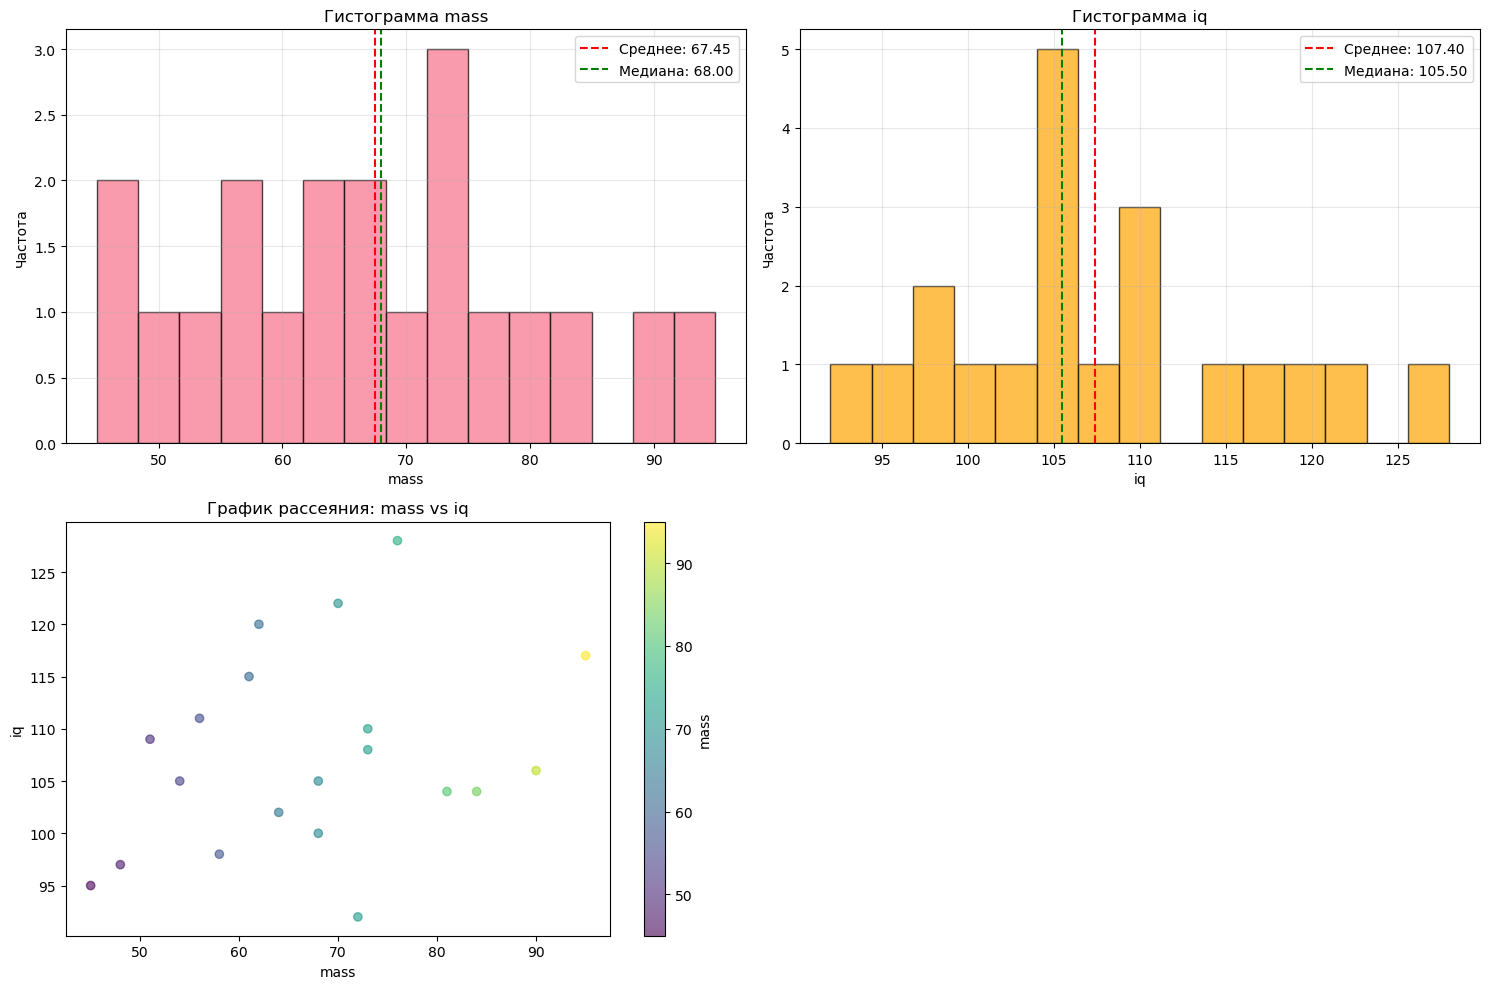

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('default')
sns.set_palette("husl")

print(f"Визуализация данных: '{col1}' vs '{col2}'")

fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(df[col1].dropna(), bins=15, alpha=0.7, edgecolor='black')
plt.title(f'Гистограмма {col1}')
plt.xlabel(col1)
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

mean_val1 = df[col1].mean()
median_val1 = df[col1].median()
plt.axvline(mean_val1, color='red', linestyle='--', label=f'Среднее: {mean_val1:.2f}')
plt.axvline(median_val1, color='green', linestyle='--', label=f'Медиана: {median_val1:.2f}')
plt.legend()

plt.subplot(2, 2, 2)
plt.hist(df[col2].dropna(), bins=15, alpha=0.7, edgecolor='black', color='orange')
plt.title(f'Гистограмма {col2}')
plt.xlabel(col2)
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

mean_val2 = df[col2].mean()
median_val2 = df[col2].median()
plt.axvline(mean_val2, color='red', linestyle='--', label=f'Среднее: {mean_val2:.2f}')
plt.axvline(median_val2, color='green', linestyle='--', label=f'Медиана: {median_val2:.2f}')
plt.legend()

plt.subplot(2, 2, 3)
scatter = plt.scatter(df[col1], df[col2], alpha=0.6, c=df[col1], cmap='viridis')
plt.title(f'График рассеяния: {col1} vs {col2}')
plt.xlabel(col1)
plt.ylabel(col2)
plt.colorbar(scatter, label=col1)

plt.tight_layout()
plt.show()

## 3. Уравнение регрессии


1. ЛИНЕЙНАЯ: y = 0.2047*x + 93.5960
   R² = 0.0880

2. КВАДРАТИЧНАЯ: y = -0.0073*x² + 1.2189*x + 59.8352
   R² = 0.1143

3. ГИПЕРБОЛИЧЕСКАЯ: y = -987.8951/x + 122.6362
   R² = 0.1126

4. ПОКАЗАТЕЛЬНАЯ: y = 94.6455 * 1.0019^x
   R² = 0.0867


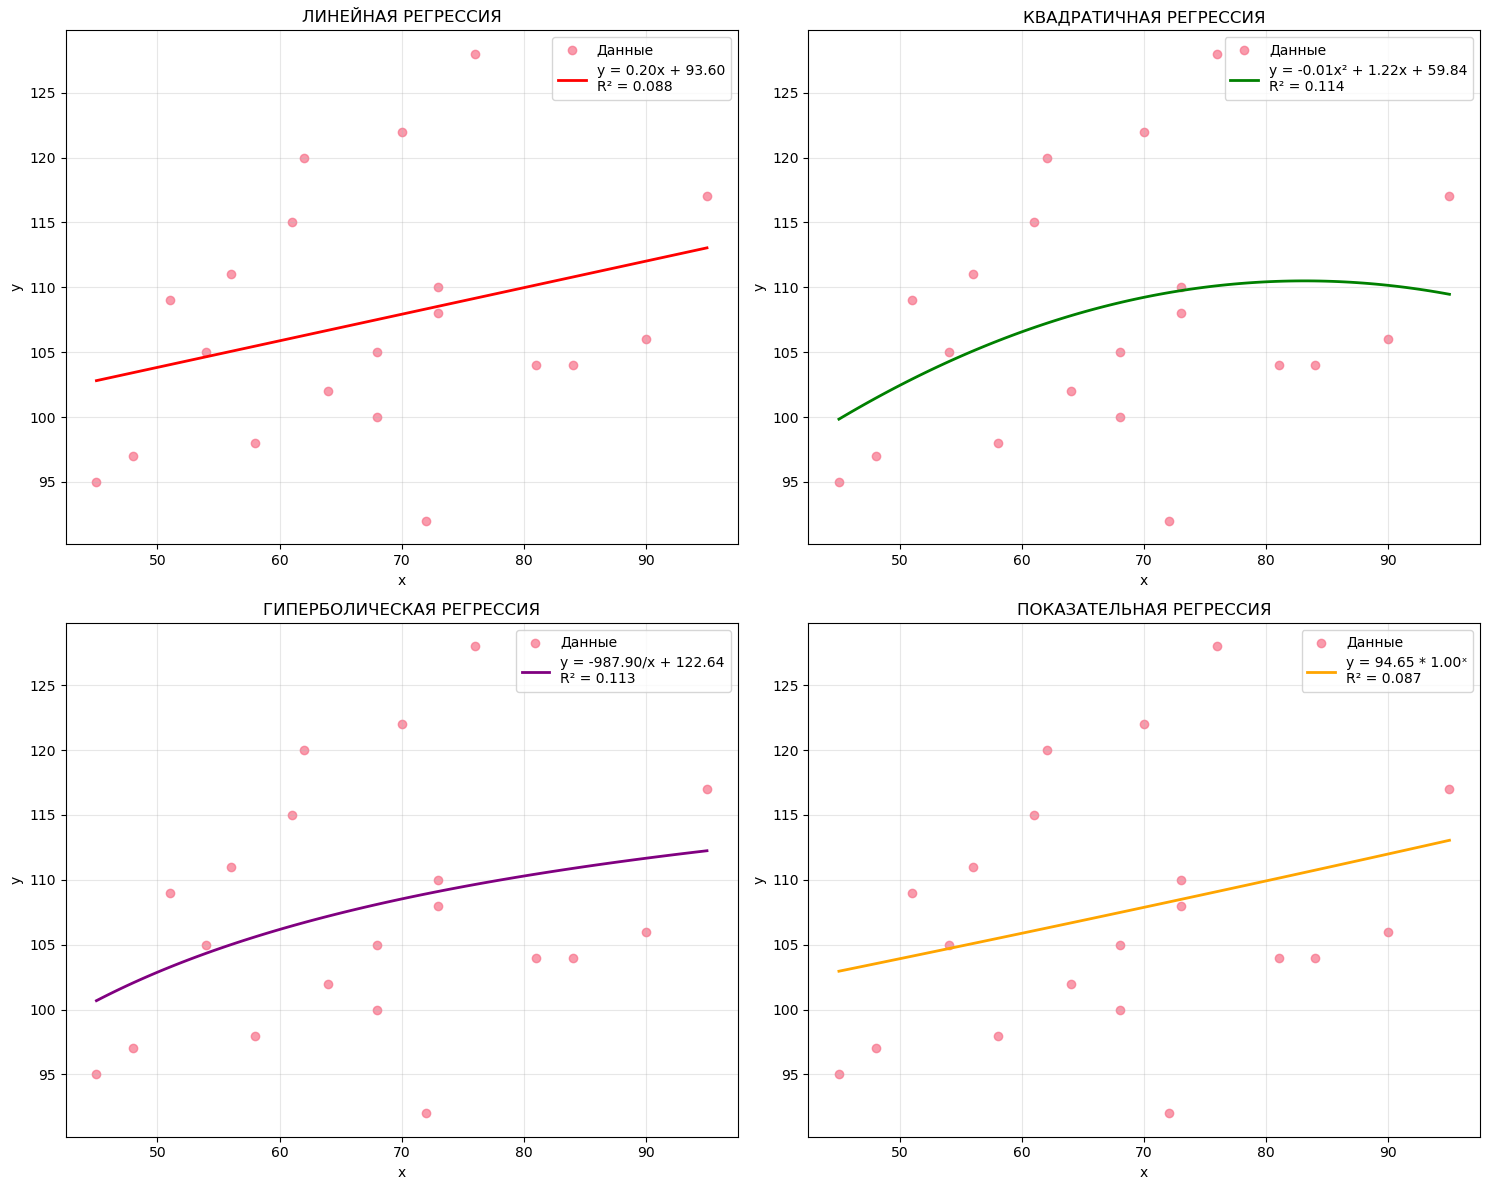


Модели в порядке убывания качества (по R²):
1. Квадратичная    R² = 0.1143
2. Гиперболическая R² = 0.1126
3. Линейная        R² = 0.0880
4. Показательная   R² = 0.0867


In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

x = df[col1]
y = df[col2]

def calculate_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return 1 - (ss_res / ss_tot)

def linear_regression_manual(x, y):
    n = len(x)
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    w1 = (np.sum(x*y) - n*x_mean*y_mean) / (np.sum(x*x) - n*x_mean*x_mean)
    w0 = y_mean - w1 * x_mean
    
    y_pred = w1 * x + w0
    r_squared = calculate_r_squared(y, y_pred)
    
    return w0, w1, r_squared, y_pred

def quadratic_regression_lib(x, y):
    coefficients = np.polyfit(x, y, 2)
    w2, w1, w0 = coefficients
    
    y_pred = np.polyval(coefficients, x)
    r_squared = calculate_r_squared(y, y_pred)
    
    return w0, w1, w2, r_squared, y_pred

def hyperbolic_regression_lib(x, y):
    def hyperbolic_func(x, w1, w0):
        return w1 / x + w0
    
    params, _ = curve_fit(hyperbolic_func, x, y, p0=[1.0, 1.0])
    w1, w0 = params
    
    y_pred = hyperbolic_func(x, w1, w0)
    r_squared = calculate_r_squared(y, y_pred)
    
    return w0, w1, r_squared, y_pred

def exponential_regression_lib(x, y):
    def exponential_func(x, w0, w1):
        return w0 * (w1 ** x)
    
    params, _ = curve_fit(exponential_func, x, y, p0=[1.0, 1.0], maxfev=5000)
    w0, w1 = params
    
    y_pred = exponential_func(x, w0, w1)
    r_squared = calculate_r_squared(y, y_pred)
    
    return w0, w1, r_squared, y_pred

w0_lin, w1_lin, r2_lin, y_pred_lin = linear_regression_manual(x, y)
print(f"\n1. ЛИНЕЙНАЯ: y = {w1_lin:.4f}*x + {w0_lin:.4f}")
print(f"   R² = {r2_lin:.4f}")

w0_quad, w1_quad, w2_quad, r2_quad, y_pred_quad = quadratic_regression_lib(x, y)
print(f"\n2. КВАДРАТИЧНАЯ: y = {w2_quad:.4f}*x² + {w1_quad:.4f}*x + {w0_quad:.4f}")
print(f"   R² = {r2_quad:.4f}")

w0_hyp, w1_hyp, r2_hyp, y_pred_hyp = hyperbolic_regression_lib(x, y)
print(f"\n3. ГИПЕРБОЛИЧЕСКАЯ: y = {w1_hyp:.4f}/x + {w0_hyp:.4f}")
print(f"   R² = {r2_hyp:.4f}")

w0_exp, w1_exp, r2_exp, y_pred_exp = exponential_regression_lib(x, y)
print(f"\n4. ПОКАЗАТЕЛЬНАЯ: y = {w0_exp:.4f} * {w1_exp:.4f}^x")
print(f"   R² = {r2_exp:.4f}")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
x_smooth = np.linspace(x.min(), x.max(), 100)

axes[0, 0].scatter(x, y, alpha=0.7, label='Данные')
axes[0, 0].plot(x_smooth, w1_lin*x_smooth + w0_lin, 'r-', linewidth=2, 
                label=f'y = {w1_lin:.2f}x + {w0_lin:.2f}\nR² = {r2_lin:.3f}')
axes[0, 0].set_title('ЛИНЕЙНАЯ РЕГРЕССИЯ')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].scatter(x, y, alpha=0.7, label='Данные')
axes[0, 1].plot(x_smooth, w2_quad*x_smooth**2 + w1_quad*x_smooth + w0_quad, 'g-', linewidth=2,
                label=f'y = {w2_quad:.2f}x² + {w1_quad:.2f}x + {w0_quad:.2f}\nR² = {r2_quad:.3f}')
axes[0, 1].set_title('КВАДРАТИЧНАЯ РЕГРЕССИЯ')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].scatter(x, y, alpha=0.7, label='Данные')
x_smooth_pos = x_smooth[x_smooth > 0]  # избегаем деления на 0
axes[1, 0].plot(x_smooth_pos, w1_hyp/x_smooth_pos + w0_hyp, 'purple', linewidth=2,
                label=f'y = {w1_hyp:.2f}/x + {w0_hyp:.2f}\nR² = {r2_hyp:.3f}')
axes[1, 0].set_title('ГИПЕРБОЛИЧЕСКАЯ РЕГРЕССИЯ')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(x, y, alpha=0.7, label='Данные')
axes[1, 1].plot(x_smooth, w0_exp * (w1_exp ** x_smooth), 'orange', linewidth=2,
                label=f'y = {w0_exp:.2f} * {w1_exp:.2f}ˣ\nR² = {r2_exp:.3f}')
axes[1, 1].set_title('ПОКАЗАТЕЛЬНАЯ РЕГРЕССИЯ')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

models = [
    ("Линейная", r2_lin),
    ("Квадратичная", r2_quad), 
    ("Гиперболическая", r2_hyp),
    ("Показательная", r2_exp)
]

# Сортируем по качеству (R²)
models.sort(key=lambda x: x[1], reverse=True)

print("\nМодели в порядке убывания качества (по R²):")
for i, (name, r2) in enumerate(models, 1):
    print(f"{i}. {name:15} R² = {r2:.4f}")

Значение метрики R^2 очень маленькое, следовательно модель имеет слабые предсказательные способности, что связано с тем, что признаки слабо коррелируют между собой

## 4. Проверка уравнения регрессии

In [73]:
def fisher_f_test(y_true, y_pred, k, alpha=0.05):
    n = len(y_true)
    
    ss_res = np.sum((y_true - y_pred)**2) 
    ss_reg = np.sum((y_pred - np.mean(y_true))**2)  
    
    # Степени свободы
    df_reg = k  # для регрессии
    df_res = n - k - 1  # для остатков
    
    # Средние квадраты
    ms_reg = ss_reg / df_reg if df_reg > 0 else 0
    ms_res = ss_res / df_res if df_res > 0 else 0
    
    # F-статистика
    f_statistic = ms_reg / ms_res if ms_res > 0 else 0
    
    # Критическое значение F-распределения
    f_critical = stats.f.ppf(1 - alpha, df_reg, df_res)
    
    # P-value
    p_value = 1 - stats.f.cdf(f_statistic, df_reg, df_res)
    
    # Вывод
    if f_statistic > f_critical:
        conclusion = "Модель статистически значима (отвергаем H0)"
    else:
        conclusion = "Модель не значима (не отвергаем H0)"
    
    return {
        'f_statistic': f_statistic,
        'f_critical': f_critical,
        'p_value': p_value,
        'ss_reg': ss_reg,
        'ss_res': ss_res,
        'ms_reg': ms_reg,
        'ms_res': ms_res,
        'df_reg': df_reg,
        'df_res': df_res,
        'conclusion': conclusion
    }

best_y_pred = y_pred_quad
best_k = 1 
best_name = "Квадратичная" 

worst_y_pred = y_pred_exp
worst_k = 1  
worst_name = "Показательная" 

# Уровень значимости
alpha = 0.05

print(f"\nНАИЛУЧШАЯ МОДЕЛЬ: {best_name}")
f_test_best = fisher_f_test(y, best_y_pred, best_k, alpha)

print(f"F-статистика: {f_test_best['f_statistic']:.4f}")
print(f"Критическое значение F({f_test_best['df_reg']}, {f_test_best['df_res']}): {f_test_best['f_critical']:.4f}")
print(f"P-value: {f_test_best['p_value']:.6f}")
print(f"Вывод: {f_test_best['conclusion']}")

print(f"\nНАИХУДШАЯ МОДЕЛЬ: {worst_name}")
f_test_worst = fisher_f_test(y, worst_y_pred, worst_k, alpha)

print(f"F-статистика: {f_test_worst['f_statistic']:.4f}")
print(f"Критическое значение F({f_test_worst['df_reg']}, {f_test_worst['df_res']}): {f_test_worst['f_critical']:.4f}")
print(f"P-value: {f_test_worst['p_value']:.6f}")
print(f"Вывод: {f_test_worst['conclusion']}")



НАИЛУЧШАЯ МОДЕЛЬ: Квадратичная
F-статистика: 2.3232
Критическое значение F(1, 18): 4.4139
P-value: 0.144837
Вывод: Модель не значима (не отвергаем H0)

НАИХУДШАЯ МОДЕЛЬ: Показательная
F-статистика: 1.6817
Критическое значение F(1, 18): 4.4139
P-value: 0.211080
Вывод: Модель не значима (не отвергаем H0)
